In this notebook I will try to predict fraud transactions from a given data set. Given that the data is imbalanced, standard metrics for evaluating classification algorithm (such as accuracy) are invalid. I will focus on the following metrics: Sensitivity (true positive rate) and Specificity (true negative rate). Of course, they are dependent on each other, so we want to find optimal trade-off between them. Such trade-off usually depends on the application of the algorithm, and in case of fraud detection I would prefer to see high sensitivity (e.g. given that a transaction is fraud, I want to be able to detect it with high probability).

**IMPORTING LIBRARIES:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPRegressor
from scipy.stats import multivariate_normal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

2025-06-08 17:15:19.244113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749402919.436710      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749402919.490069      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**READING DATASET :**

In [3]:
data=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**NULL VALUES:**

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Thus there are no null values in the dataset.**

**INFORMATION**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**DESCRIPTIVE STATISTICS**

In [7]:
data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.369007e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344


In [8]:
data.shape

(284807, 31)

**Thus there are 284807 rows and 31 columns.**

In [9]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**FRAUD CASES AND GENUINE CASES**

In [10]:
fraud_cases=len(data[data['Class']==1])

In [11]:
print(' Number of Fraud Cases:',fraud_cases)

 Number of Fraud Cases: 492


In [12]:
non_fraud_cases=len(data[data['Class']==0])

In [13]:
print('Number of Non Fraud Cases:',non_fraud_cases)

Number of Non Fraud Cases: 284315


In [14]:
fraud=data[data['Class']==1]

In [15]:
genuine=data[data['Class']==0]

In [16]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
genuine.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

**EDA**

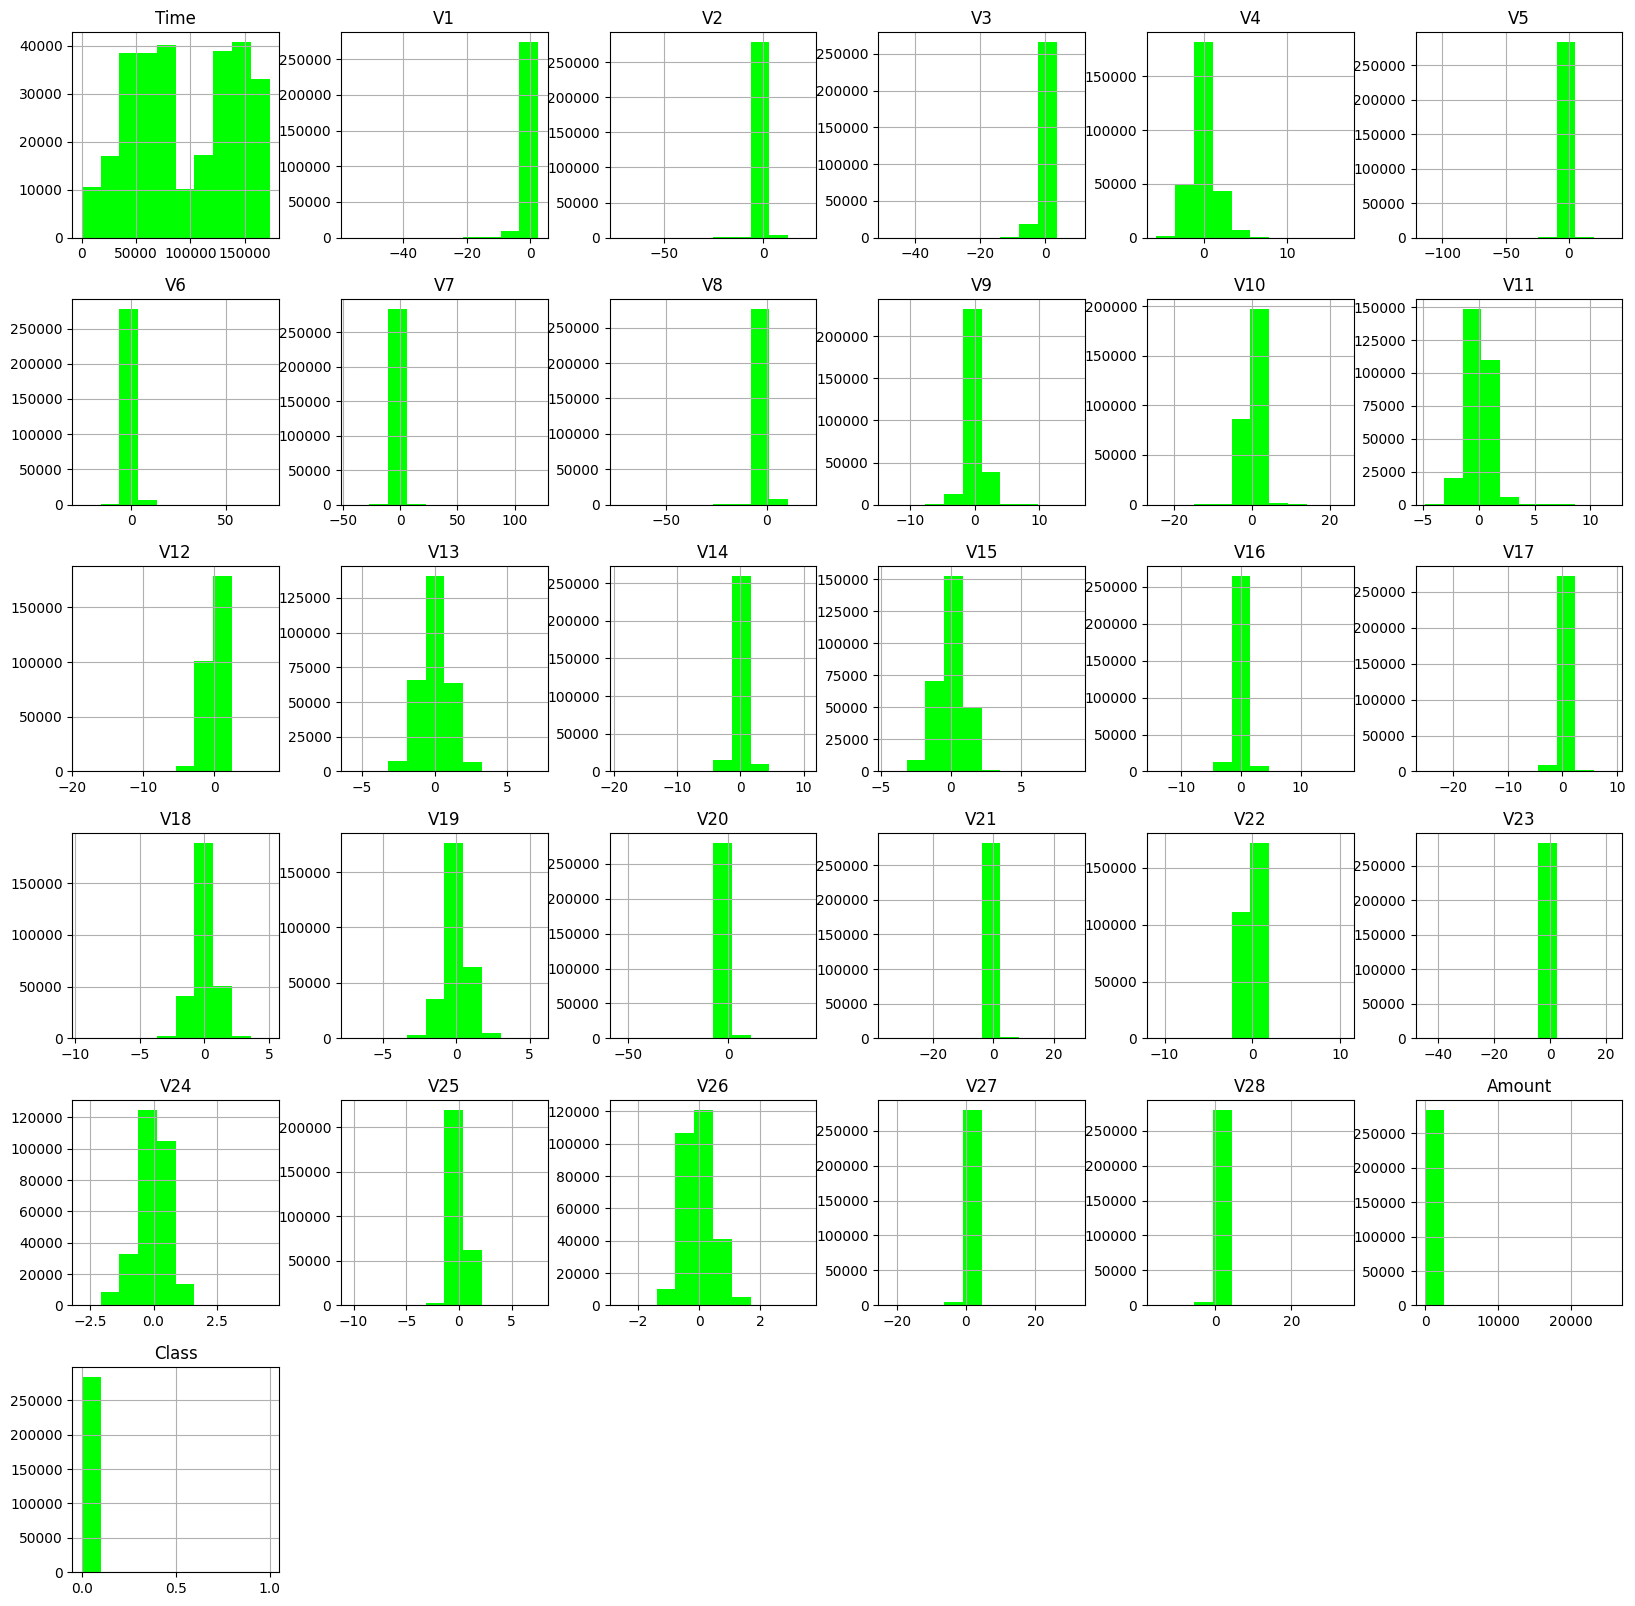

In [18]:
data.hist(figsize=(20,20),color='lime')
plt.show()

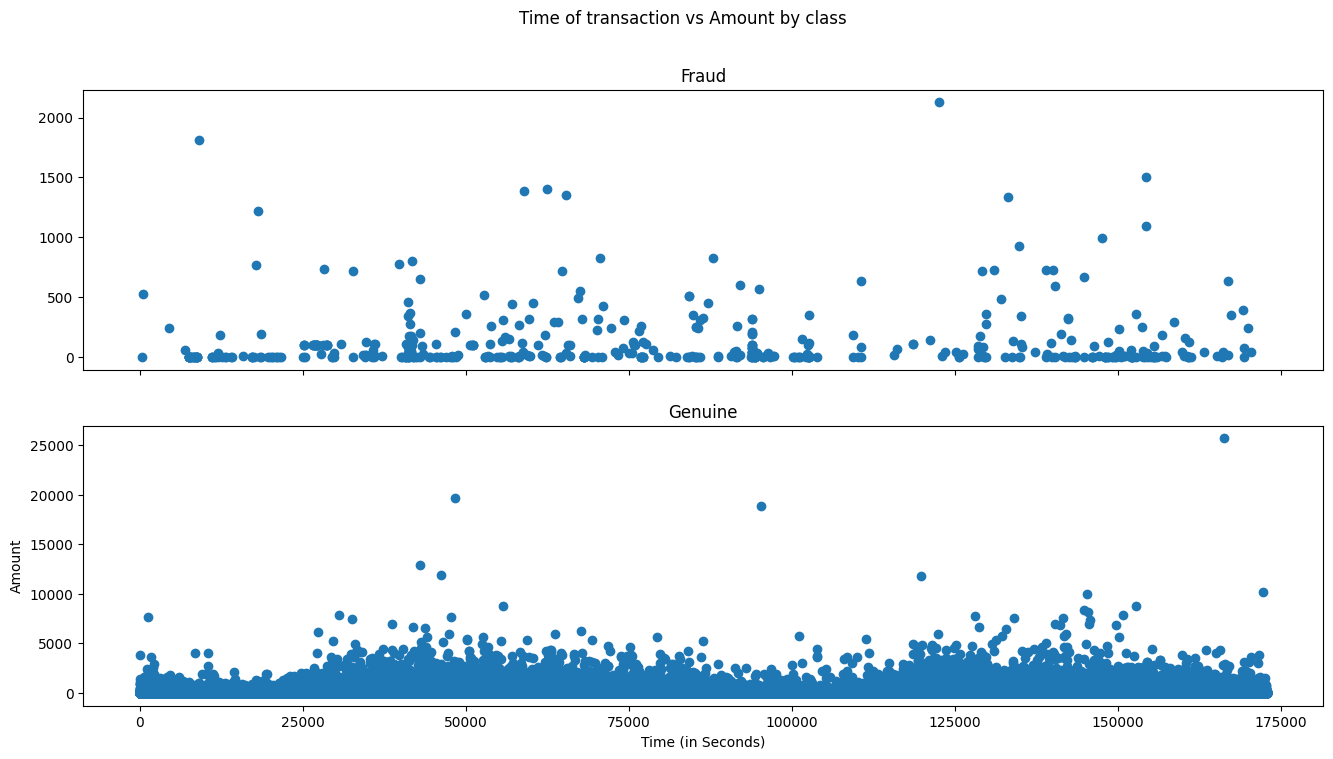

In [19]:
rcParams['figure.figsize'] = 16, 8
f,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(genuine.Time, genuine.Amount)
ax2.set_title('Genuine')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


**CORRELATION**

<Axes: >

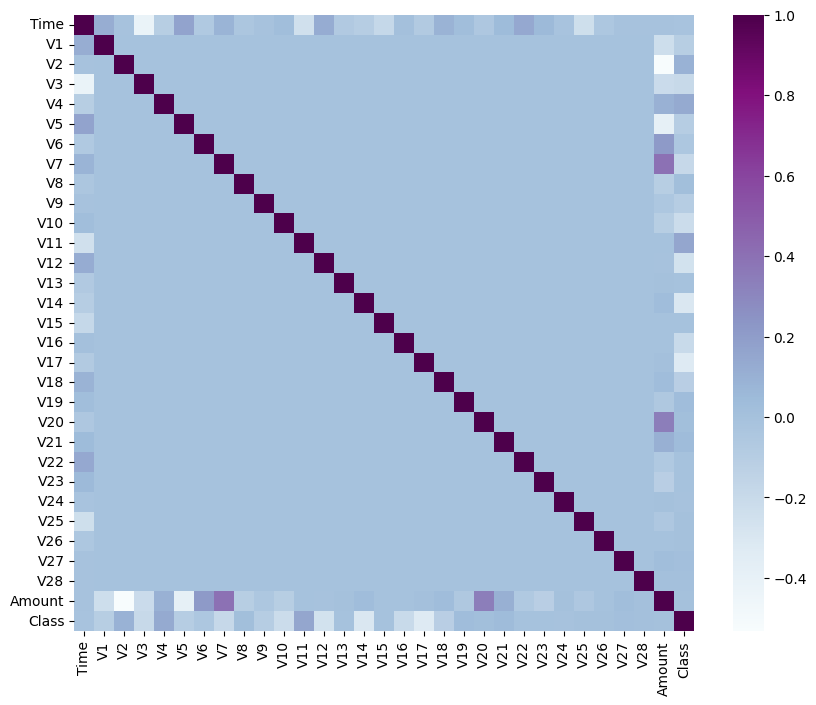

In [20]:
plt.figure(figsize=(10,8))
corr=data.corr()
sns.heatmap(corr,cmap='BuPu')

**Let us build our models:**

In [21]:
from sklearn.model_selection import train_test_split

**Model 1:**

In [22]:
X=data.drop(['Class'],axis=1)

In [23]:
y=data['Class']

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=123)

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rfc=RandomForestClassifier()

In [27]:
model=rfc.fit(X_train,y_train)

In [28]:
prediction=model.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_test,prediction)

0.9994967405170698

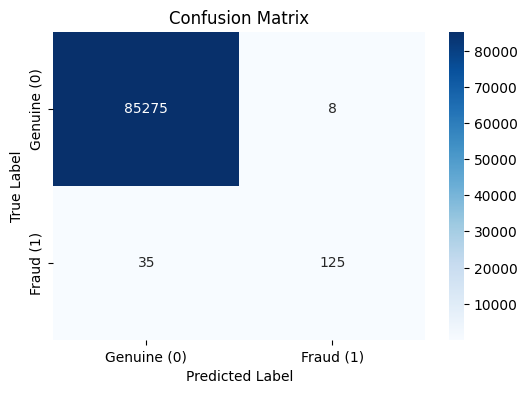

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine (0)', 'Fraud (1)'], yticklabels=['Genuine (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Model 2:**

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
X1=data.drop(['Class'],axis=1)

In [34]:
y1=data['Class']

In [35]:
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.3,random_state=123)

In [36]:
lr=LogisticRegression()

In [37]:
model2=lr.fit(X1_train,y1_train)

In [38]:
prediction2=model2.predict(X1_test)

In [39]:
accuracy_score(y1_test,prediction2)

0.9988881476539916

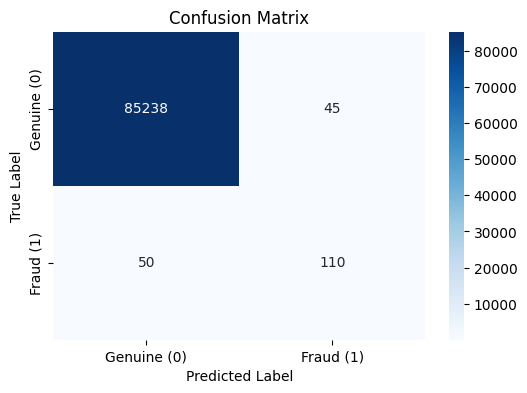

In [40]:
cm = confusion_matrix(y1_test, prediction2)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine (0)', 'Fraud (1)'], yticklabels=['Genuine (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Model 3:**

In [41]:
from sklearn.tree import DecisionTreeRegressor

In [42]:
X2=data.drop(['Class'],axis=1)

In [43]:
y2=data['Class']

In [44]:
dt=DecisionTreeRegressor()

In [45]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.3,random_state=123)

In [46]:
model3=dt.fit(X2_train,y2_train)

In [47]:
prediction3=model3.predict(X2_test)

In [48]:
accuracy_score(y2_test,prediction3)

0.99916903666772

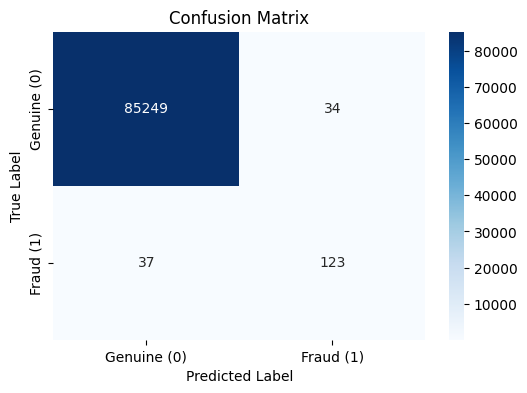

In [49]:
cm = confusion_matrix(y2_test, prediction3)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine (0)', 'Fraud (1)'], yticklabels=['Genuine (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**All of our models performed with a very high accuracy.**

## Using Reinforcement Learning for Fraud Detection

Yes, Reinforcement Learning (RL) can be employed to solve the problem of credit card fraud detection.

Here's a general idea of how it could be approached:

*   **Agent:** The RL agent would be the model making decisions about whether a transaction is fraudulent or not.
*   **Environment:** The stream of incoming credit card transactions.
*   **State:** The features of a current transaction (e.g., amount, time, location, historical transaction patterns of the user).
*   **Actions:** The agent can decide to classify a transaction as 'fraudulent' or 'genuine'.
*   **Reward/Penalty:**
    *   **Reward:** Correctly identifying a fraudulent transaction or correctly identifying a genuine transaction.
    *   **Penalty:** Incorrectly classifying a genuine transaction as fraud (false positive) or failing to detect a fraudulent transaction (false negative). The penalties for false negatives are typically much higher in fraud detection.

The agent learns a policy (a way of behaving) by interacting with the transaction data. It tries to maximize its cumulative reward over time. This often involves an online learning approach where the model adapts as new transactions and feedback (e.g., chargebacks, user reports) become available.

RL can be particularly useful in scenarios where:

*   Fraud patterns evolve rapidly, requiring the model to adapt quickly.
*   There's a need to balance the detection of fraud with minimizing inconvenience to legitimate users (false positives).
*   The cost of misclassification varies significantly (e.g., missing a large fraudulent transaction is much worse than a small one).

However, implementing RL for fraud detection can be complex due to challenges like:

*   **Delayed Rewards:** It might take time to confirm if a transaction was truly fraudulent.
*   **Exploration vs. Exploitation:** The agent needs to explore new patterns while exploiting known ones.
*   **Highly Imbalanced Data:** Fraudulent transactions are rare, which can make learning difficult.

## Reinforcement Learning Approach: Contextual Bandits (LinUCB)

We will now explore a Reinforcement Learning (RL) technique called **Contextual Bandits** to address the fraud detection problem. Specifically, we'll implement the **LinUCB (Linear Upper Confidence Bound)** algorithm.

In this framework:
*   **Agent**: The LinUCB algorithm itself, which decides whether to classify a transaction as fraudulent or genuine.
*   **Context (State)**: The features of each transaction (e.g., scaled 'Time', 'Amount', and V1-V28 components).
*   **Actions**: Two possible actions:
    *   Action 0: Classify the transaction as genuine.
    *   Action 1: Classify the transaction as fraudulent.
*   **Reward**: The agent receives a reward based on the correctness of its action. The reward structure is designed to heavily penalize missed frauds (False Negatives) and also penalize false alarms (False Positives), while rewarding correct classifications.

LinUCB is suitable here because it can leverage the transaction features (context) to make informed decisions and balances exploration (trying out actions to learn more) with exploitation (choosing the action believed to be best). We will train the agent on the training set and then evaluate its performance on the test set.

In [50]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data for RL (LinUCB)
# Use copies to avoid altering dataframes used by previous models
X_train_rl = X_train.copy()
X_test_rl = X_test.copy()
y_train_rl = y_train.copy().values # Convert to numpy array
y_test_rl = y_test.copy().values  # Convert to numpy array

# Scale the features
# The V1-V28 features are already PCA components, but Time and Amount need scaling.
# For simplicity and robustness with LinUCB, we'll scale all features.
scaler = StandardScaler()
X_train_scaled_rl = scaler.fit_transform(X_train_rl)
X_test_scaled_rl = scaler.transform(X_test_rl)

# Add a bias term (intercept) to the feature vectors for LinUCB
X_train_scaled_rl = np.concatenate((np.ones((X_train_scaled_rl.shape[0], 1)), X_train_scaled_rl), axis=1)
X_test_scaled_rl = np.concatenate((np.ones((X_test_scaled_rl.shape[0], 1)), X_test_scaled_rl), axis=1)

print("Shape of scaled training features with bias:", X_train_scaled_rl.shape)
print("Shape of scaled test features with bias:", X_test_scaled_rl.shape)

Shape of scaled training features with bias: (199364, 31)
Shape of scaled test features with bias: (85443, 31)


In [51]:
class LinUCBAgent:
    def __init__(self, n_actions, n_features, alpha=1.0):
        self.n_actions = n_actions
        self.n_features = n_features
        self.alpha = alpha

        # Initialize A as a list of identity matrices (one for each action)
        # A stores X.T * X for each arm
        self.A = [np.identity(n_features) for _ in range(n_actions)]
        # Initialize b as a list of zero vectors (one for each action)
        # b stores X.T * r for each arm
        self.b = [np.zeros(n_features) for _ in range(n_actions)]
        
        self.theta = [np.zeros(n_features) for _ in range(n_actions)]

    def predict(self, context):
        # context is a d-dimensional feature vector
        ucb_scores = np.zeros(self.n_actions)
        for action in range(self.n_actions):
            A_inv = np.linalg.inv(self.A[action])
            self.theta[action] = A_inv @ self.b[action] # theta = A_inv * b
            
            # UCB calculation: theta.T * x + alpha * sqrt(x.T * A_inv * x)
            term1 = self.theta[action] @ context
            term2 = self.alpha * np.sqrt(context @ A_inv @ context)
            ucb_scores[action] = term1 + term2
        
        # Choose action with the highest UCB score
        chosen_action = np.argmax(ucb_scores)
        return chosen_action

    def update(self, action, context, reward):
        # Update A and b for the chosen action
        # context is (d,)
        # A_a = A_a + x_t * x_t.T
        # b_a = b_a + r_t * x_t
        self.A[action] += np.outer(context, context) # outer product for x * x.T
        self.b[action] += reward * context

# Example instantiation (parameters will be set during training)
# agent_linucb = LinUCBAgent(n_actions=2, n_features=X_train_scaled_rl.shape[1], alpha=1.0)
# print("LinUCB agent initialized.")

In [52]:
def get_reward_fraud(predicted_action, true_label):
    """
    Defines the reward structure for fraud detection.
    Actions: 0 for genuine, 1 for fraud.
    """
    if predicted_action == 1: # Predicted Fraud
        if true_label == 1: # True Positive
            return 10  # Correctly detected fraud
        else: # False Positive
            return -5 # Incorrectly flagged genuine as fraud
    else: # Predicted Genuine
        if true_label == 0: # True Negative
            return 1   # Correctly identified genuine
        else: # False Negative
            return -100 # Missed a fraud - high penalty
    
# Initialize LinUCB agent
n_actions = 2 # 0 for genuine, 1 for fraud
n_features = X_train_scaled_rl.shape[1] # Number of features including bias
alpha_value = 0.1 # Exploration parameter (can be tuned)

agent_linucb = LinUCBAgent(n_actions=n_actions, n_features=n_features, alpha=alpha_value)

# "Train" the LinUCB agent on the training data
# This involves iterating through the training set and updating the agent's parameters
cumulative_reward_train = 0
train_predictions_rl = []

print(f"Starting LinUCB training on {X_train_scaled_rl.shape[0]} samples...")
for i in range(X_train_scaled_rl.shape[0]):
    context = X_train_scaled_rl[i]
    true_label = y_train_rl[i]
    
    action = agent_linucb.predict(context)
    reward = get_reward_fraud(action, true_label)
    
    agent_linucb.update(action, context, reward)
    
    cumulative_reward_train += reward
    train_predictions_rl.append(action)
    
    if (i + 1) % 20000 == 0:
        print(f"Processed {i+1}/{X_train_scaled_rl.shape[0]} training samples. Cumulative reward: {cumulative_reward_train}")

print(f"LinUCB training completed. Total cumulative reward on training set: {cumulative_reward_train}")

Starting LinUCB training on 199364 samples...
Processed 20000/199364 training samples. Cumulative reward: 19150
Processed 40000/199364 training samples. Cumulative reward: 38955
Processed 60000/199364 training samples. Cumulative reward: 58746
Processed 80000/199364 training samples. Cumulative reward: 77833
Processed 100000/199364 training samples. Cumulative reward: 97433
Processed 120000/199364 training samples. Cumulative reward: 116855
Processed 140000/199364 training samples. Cumulative reward: 136260
Processed 160000/199364 training samples. Cumulative reward: 156012
Processed 180000/199364 training samples. Cumulative reward: 175618
LinUCB training completed. Total cumulative reward on training set: 194722


Starting LinUCB evaluation on 85443 samples...
Processed 10000/85443 test samples. Cumulative reward: 9864
Processed 20000/85443 test samples. Cumulative reward: 19413
Processed 30000/85443 test samples. Cumulative reward: 29298
Processed 40000/85443 test samples. Cumulative reward: 39094
Processed 50000/85443 test samples. Cumulative reward: 49042
Processed 60000/85443 test samples. Cumulative reward: 58618
Processed 70000/85443 test samples. Cumulative reward: 68340
Processed 80000/85443 test samples. Cumulative reward: 78254
LinUCB evaluation completed. Total cumulative reward on test set: 83605

LinUCB - Accuracy on Test Set: 0.9987

LinUCB - Classification Report on Test Set:
              precision    recall  f1-score   support

 Genuine (0)     0.9997    0.9990    0.9993     85283
   Fraud (1)     0.6054    0.8438    0.7050       160

    accuracy                         0.9987     85443
   macro avg     0.8025    0.9214    0.8521     85443
weighted avg     0.9990    0.9987    0

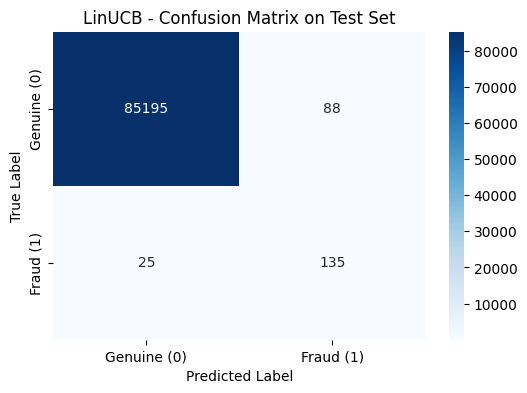

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluate the trained LinUCB agent on the test set
test_predictions_rl = []
cumulative_reward_test = 0

print(f"Starting LinUCB evaluation on {X_test_scaled_rl.shape[0]} samples...")
for i in range(X_test_scaled_rl.shape[0]):
    context = X_test_scaled_rl[i]
    true_label = y_test_rl[i] # Actual label from the test set
    
    # Get action from the trained agent (exploitation based on learned A and b)
    action = agent_linucb.predict(context) 
    reward = get_reward_fraud(action, true_label) # Calculate reward based on actual label
    
    test_predictions_rl.append(action)
    cumulative_reward_test += reward
    
    if (i + 1) % 10000 == 0:
        print(f"Processed {i+1}/{X_test_scaled_rl.shape[0]} test samples. Cumulative reward: {cumulative_reward_test}")

print(f"LinUCB evaluation completed. Total cumulative reward on test set: {cumulative_reward_test}")

# Calculate and print evaluation metrics
accuracy_rl = accuracy_score(y_test_rl, test_predictions_rl)
print(f"\nLinUCB - Accuracy on Test Set: {accuracy_rl:.4f}")

print("\nLinUCB - Classification Report on Test Set:")
# Note: target_names=['Genuine (0)', 'Fraud (1)']
print(classification_report(y_test_rl, test_predictions_rl, target_names=['Genuine (0)', 'Fraud (1)'], digits=4))

print("\nLinUCB - Confusion Matrix on Test Set:")
cm_rl = confusion_matrix(y_test_rl, test_predictions_rl)
print(cm_rl)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_rl, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine (0)', 'Fraud (1)'], yticklabels=['Genuine (0)', 'Fraud (1)'])
plt.title('LinUCB - Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Discussion of LinUCB Results

The LinUCB model's performance can now be assessed based on the metrics above.

*   **Cumulative Reward**: This gives an overall sense of how well the agent performed according to our defined reward structure.
*   **Accuracy**: While high accuracy is common in imbalanced datasets, it's not the primary metric for fraud detection.
*   **Precision, Recall, F1-Score (for Fraud class)**: These are critical.
    *   **Recall (Sensitivity)** for the 'Fraud (1)' class tells us what proportion of actual frauds the model correctly identified. This is very important as missing frauds (False Negatives) is costly.
    *   **Precision** for the 'Fraud (1)' class tells us what proportion of transactions flagged as fraud were actually fraudulent. Low precision means many false alarms (False Positives).
*   **Confusion Matrix**: Provides a detailed breakdown of True Positives, True Negatives, False Positives, and False Negatives.

Compare these results to the supervised learning models (Random Forest, Logistic Regression, Decision Tree). The LinUCB approach might offer different trade-offs, especially if the reward function accurately reflects the real-world costs and benefits.

**Limitations & Potential Improvements:**
*   **Alpha Parameter**: The `alpha` value in LinUCB controls the exploration-exploitation balance. This was set to 0.1 but could be tuned for better performance.
*   **Reward Structure**: The defined rewards are heuristic. Fine-tuning them can significantly impact the agent's behavior.
*   **Static Dataset**: RL agents typically learn best in interactive environments. Here, we simulate this by processing a static dataset sequentially.
*   **Feature Engineering**: More sophisticated feature engineering could improve performance.
*   **Non-stationarity**: If fraud patterns change over time (which they do in reality), the LinUCB model (or any model) would need to be retrained or adapted. Online learning capabilities of bandits are beneficial here.

This implementation provides a foundational example of applying a contextual bandit algorithm to fraud detection.

## Additional Classical RL Approaches for Fraud Detection
While we've implemented the LinUCB algorithm (a contextual bandit approach), there are several other classical RL algorithms that could be applied to the credit card fraud detection problem:

### 1. Q-Learning
**How it could be applied:**
* **States:** The feature vectors of transactions
* **Actions:** Classify as genuine (0) or fraud (1)
* **Rewards:** Similar to our current reward structure
* **Implementation approach:** Since the state space is large (continuous), function approximation would be required, such as using a linear function or neural network to represent the Q-function

### 2. SARSA (State-Action-Reward-State-Action)
**How it could be applied:**
* Similar to Q-learning but uses an on-policy approach
* More conservative than Q-learning, which might be beneficial in fraud detection where false positives can be costly
* Could provide a different balance of precision vs. recall

### 3. Asynchronous Advantage Actor-Critic (A3C)
**How it could be applied:**
* **Actor:** Neural network that learns a stochastic policy for classifying transactions
* **Critic:** Value network that estimates the expected return from each state
* **Asynchronous training:** Multiple workers can train on different data streams simultaneously, improving sample efficiency
* **Advantage function:** Helps reduce variance in policy gradient estimates, leading to more stable learning
* Particularly useful for fraud detection as it can handle continuous feature spaces and learn from sequential transaction patterns
* Can adapt quickly to changing fraud patterns through parallel exploration

### 4. Actor-Critic Methods
**How it could be applied:**
* **Actor:** Policy network that decides whether to classify a transaction as fraud or genuine
* **Critic:** Value network that evaluates how good the actor's decisions are
* Can better handle the exploration-exploitation trade-off in this imbalanced dataset
* Can incorporate a cost-sensitive learning approach directly into the reward structure

### 5. Thompson Sampling
**How it could be applied:**
* An alternative to UCB for the multi-armed bandit/contextual bandit approach
* Bayesian approach that maintains a distribution over expected rewards
* May handle uncertainty better in cases where fraud patterns are changing

### 6. Deep Q-Network (DQN)
**How it could be applied:**
* Uses deep neural networks to approximate the Q-function
* Can capture complex non-linear relationships in the transaction features
* Memory replay could help with the class imbalance problem by storing and reusing fraud examples

### 7. Proximal Policy Optimization (PPO)
**How it could be applied:**
* **Policy optimization:** Directly optimizes the policy that classifies transactions as fraud or genuine
* **Clipped objective:** Prevents large policy updates that could destabilize learning, which is crucial in fraud detection where stability is important
* **Sample efficiency:** More sample-efficient than basic policy gradient methods, important given the rarity of fraud examples
* **Adaptive learning:** Can adjust to changing fraud patterns while maintaining stability
* **Risk management:** The clipping mechanism helps prevent catastrophic policy changes that could lead to high false positive rates
* Can incorporate business constraints directly into the objective function, such as maintaining acceptable false positive rates

### 8. Policy Gradient Methods
**How it could be applied:**
* Directly learn the policy without the intermediate step of learning a value function
* Can incorporate risk sensitivity more directly
* Methods like REINFORCE could be used as a baseline comparison

To implement any of these algorithms, additional preprocessing steps might be needed. For example, discretizing the continuous state space or using function approximation to handle the large state space. The reward structure could also be further refined to better reflect the business goals of fraud detection, such as incorporating the actual monetary value of transactions into the reward calculation.

## Let's Implement and Compare These RL Algorithms

We'll now implement several of these RL algorithms and compare their performances on the credit card fraud detection task. For each algorithm, we'll:
1. Prepare the data as needed
2. Implement the algorithm
3. Train it on the same training set
4. Evaluate it on the same test set
5. Compare the results in terms of accuracy, precision, recall, F1-score, and cumulative reward

In [54]:
print("Loading data...")
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# --- Imbalanced Dataset ---
X_imbalanced = data.drop('Class', axis=1)
y_imbalanced = data['Class']

# --- Balanced Dataset (Undersampling) ---
fraud_indices = data[data['Class'] == 1].index
normal_indices = data[data['Class'] == 0].index
n_normal = len(fraud_indices)
selected_normal_indices = np.random.choice(normal_indices, n_normal, replace=False)
undersampled_indices = np.concatenate([fraud_indices, selected_normal_indices])
X_balanced = data.loc[undersampled_indices].drop('Class', axis=1)
y_balanced = data.loc[undersampled_indices]['Class']

Loading data...


### 1. Q-Learning with Function Approximation

Since our state space (transaction features) is continuous, we'll use linear function approximation for our Q-learning implementation. This will allow us to estimate the Q-value for each action given the transaction features.

In [55]:
class LinearQAgent:
    def __init__(self, n_features, n_actions, alpha=0.01, gamma=0.95, epsilon=0.1):
        self.n_features = n_features
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.zeros((n_actions, n_features))

    def get_q_value(self, state, action):
        return np.dot(self.weights[action], state)

    def get_action(self, state, explore=True):
        if explore and np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            q_values = np.array([self.get_q_value(state, a) for a in range(self.n_actions)])
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        current_q = self.get_q_value(state, action)
        next_q_values = np.array([self.get_q_value(next_state, a) for a in range(self.n_actions)])
        max_next_q = np.max(next_q_values)
        target = reward + self.gamma * max_next_q
        td_error = target - current_q
        self.weights[action] += self.alpha * td_error * state

### 2. SARSA (State-Action-Reward-State-Action)

SARSA is an on-policy RL algorithm, meaning that it learns the value of the policy being followed. This can make it more conservative than Q-learning, which might be beneficial for fraud detection where false positives are costly.

In [56]:
class LinearSarsaAgent:
    def __init__(self, n_features, n_actions, alpha=0.01, gamma=0.95, epsilon=0.1):
        self.n_features = n_features
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.zeros((n_actions, n_features))

    def get_q_value(self, state, action):
        return np.dot(self.weights[action], state)

    def get_action(self, state, explore=True):
        if explore and np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            q_values = np.array([self.get_q_value(state, a) for a in range(self.n_actions)])
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        target = reward + self.gamma * next_q
        td_error = target - current_q
        self.weights[action] += self.alpha * td_error * state

### 3. Actor-Critic Method

Actor-Critic combines value-based and policy-based methods. It uses two components:
- **Actor**: Makes decisions about which action to take
- **Critic**: Evaluates the quality of the actions (value function)

This method can better handle the exploration-exploitation trade-off and is well-suited for fraud detection.

In [57]:
class LinearActorCriticAgent:
    def __init__(self, n_features, n_actions, actor_alpha=0.01, critic_alpha=0.01, gamma=0.95):
        self.n_features = n_features
        self.n_actions = n_actions
        self.actor_alpha = actor_alpha
        self.critic_alpha = critic_alpha
        self.gamma = gamma
        self.actor_weights = np.zeros((n_actions, n_features))
        self.critic_weights = np.zeros(n_features)

    def get_value(self, state):
        return np.dot(self.critic_weights, state)

    def get_action_probabilities(self, state):
        preferences = np.array([np.dot(self.actor_weights[a], state) for a in range(self.n_actions)])
        preferences -= np.max(preferences)
        exp_prefs = np.exp(preferences)
        return exp_prefs / np.sum(exp_prefs)

    def get_action(self, state, explore=True):
        probabilities = self.get_action_probabilities(state)
        if explore:
            return np.random.choice(self.n_actions, p=probabilities)
        else:
            return np.argmax(probabilities)

    def update(self, state, action, reward, next_state):
        current_value = self.get_value(state)
        next_value = self.get_value(next_state)
        td_error = reward + self.gamma * next_value - current_value
        self.critic_weights += self.critic_alpha * td_error * state
        self.actor_weights[action] += self.actor_alpha * td_error * state

### 4. Thompson Sampling

Thompson Sampling is a Bayesian approach to the contextual bandit problem. Unlike LinUCB which uses an upper confidence bound, Thompson Sampling maintains a probability distribution over the expected rewards and samples from this distribution to make decisions.

For fraud detection, we'll implement a version of Thompson Sampling with linear regression, where we maintain a distribution over the parameters of a linear model.

In [58]:
class LinearThompsonAgent:
    def __init__(self, n_features, n_actions, lambda_param=1.0, v_squared=1.0):
        self.n_features = n_features
        self.n_actions = n_actions
        self.lambda_param = lambda_param
        self.v_squared = v_squared
        self.B = [lambda_param * np.identity(n_features) for _ in range(n_actions)]
        self.mu = [np.zeros(n_features) for _ in range(n_actions)]
        self.f = [np.zeros(n_features) for _ in range(n_actions)]

    def update(self, context, action, reward):
        self.B[action] += np.outer(context, context)
        self.f[action] += reward * context
        self.mu[action] = np.linalg.solve(self.B[action], self.f[action])

    def predict(self, context):
        sampled_values = np.zeros(self.n_actions)
        for action in range(self.n_actions):
            try:
                cov = self.v_squared * np.linalg.inv(self.B[action])
                sampled_theta = multivariate_normal.rvs(mean=self.mu[action], cov=cov)
            except:
                sampled_theta = self.mu[action]
            sampled_values[action] = np.dot(sampled_theta, context)
        return np.argmax(sampled_values)

### 5. Deep Q-Network (DQN)

The Deep Q-Network (DQN) algorithm uses a neural network to approximate the Q-function. This can capture more complex non-linear relationships between the transaction features and the expected rewards.

For this implementation, we'll use a simple neural network from scikit-learn to create our DQN.

In [59]:
class DQNAgent:
    def __init__(self, n_features, n_actions, epsilon=0.1, gamma=0.95):
        self.n_features = n_features
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_networks = []
        for _ in range(n_actions):
            nn = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                              max_iter=1, warm_start=True, random_state=42)
            nn.fit(np.zeros((1, n_features)), np.array([0]))
            self.q_networks.append(nn)

    def get_q_value(self, state, action):
        return self.q_networks[action].predict(state.reshape(1, -1))[0]

    def get_action(self, state, explore=True):
        if explore and np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            q_values = np.array([self.get_q_value(state, a) for a in range(self.n_actions)])
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        next_q_values = np.array([self.get_q_value(next_state, a) for a in range(self.n_actions)])
        target = reward + self.gamma * np.max(next_q_values)
        self.q_networks[action].partial_fit(state.reshape(1, -1), np.array([target]))

### 6. Policy Gradient Method (REINFORCE)

Policy Gradient methods learn the policy directly, without learning a value function. For fraud detection, we'll implement a simple version of the REINFORCE algorithm, which adjusts the policy parameters in the direction of higher expected returns.

In [60]:
class REINFORCEAgent:
    def __init__(self, n_features, n_actions, alpha=0.01, gamma=0.95):
        self.n_features = n_features
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.theta = np.zeros((n_actions, n_features))
        self.states, self.actions, self.rewards = [], [], []

    def get_action_probabilities(self, state):
        preferences = np.array([np.dot(self.theta[a], state) for a in range(self.n_actions)])
        preferences -= np.max(preferences)
        exp_prefs = np.exp(preferences)
        return exp_prefs / np.sum(exp_prefs)

    def get_action(self, state, explore=True):
        probabilities = self.get_action_probabilities(state)
        if explore:
            return np.random.choice(self.n_actions, p=probabilities)
        else:
            return np.argmax(probabilities)

    def store_transition(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def update(self):
        if not self.rewards: return
        returns = np.array([r * (self.gamma ** i) for i, r in enumerate(self.rewards)])
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-9)
        for t in range(len(self.states)):
            state, action, R_t = self.states[t], self.actions[t], returns[t]
            probabilities = self.get_action_probabilities(state)
            for a in range(self.n_actions):
                gradient = state * (1 - probabilities[a]) if a == action else -state * probabilities[a]
                self.theta[a] += self.alpha * R_t * gradient
        self.states, self.actions, self.rewards = [], [], []

### 7. A3C 

(A3C - Asynchronous Actor-Critic)
A3C is an advanced actor-critic method that uses multiple agents to explore the environment in parallel. This can lead to faster convergence and better exploration of the state space. For our fraud detection task, we can implement a simplified version of A3C using a single-threaded approach.

In [61]:
import numpy as np
from collections import deque

class EnhancedA3CAgent:
    def __init__(self, n_features, n_actions, actor_lr=0.001, critic_lr=0.005, gamma=0.99, 
                 entropy_coeff=0.01, max_grad_norm=0.5, batch_size=32):
        """
        Enhanced A3C Agent for fraud detection with improved stability and performance
        
        Args:
            n_features: Number of input features
            n_actions: Number of actions (2 for binary classification)
            actor_lr: Learning rate for actor network
            critic_lr: Learning rate for critic network  
            gamma: Discount factor
            entropy_coeff: Entropy regularization coefficient
            max_grad_norm: Maximum gradient norm for clipping
            batch_size: Batch size for training updates
        """
        self.n_features = n_features
        self.n_actions = n_actions
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.entropy_coeff = entropy_coeff
        self.max_grad_norm = max_grad_norm
        self.batch_size = batch_size
        
        # Initialize networks with Xavier initialization
        self.actor_weights = np.random.normal(0, np.sqrt(2.0/n_features), (n_features, n_actions))
        self.actor_bias = np.zeros(n_actions)
        
        self.critic_weights = np.random.normal(0, np.sqrt(2.0/n_features), (n_features, 1))
        self.critic_bias = np.zeros(1)
        
        # Experience buffer
        self.experience_buffer = deque(maxlen=10000)
        
        # Adaptive learning rates with momentum
        self.actor_momentum_w = np.zeros_like(self.actor_weights)
        self.actor_momentum_b = np.zeros_like(self.actor_bias)
        self.critic_momentum_w = np.zeros_like(self.critic_weights)
        self.critic_momentum_b = np.zeros_like(self.critic_bias)
        self.momentum = 0.9
        
        # Running statistics for normalization
        self.state_mean = np.zeros(n_features)
        self.state_std = np.ones(n_features)
        self.state_count = 0
        
        # Performance tracking
        self.reward_history = deque(maxlen=1000)
        self.loss_history = deque(maxlen=100)
        
    def _normalize_state(self, state):
        """Online state normalization for better stability"""
        self.state_count += 1
        
        # Update running mean and std
        delta = state - self.state_mean
        self.state_mean += delta / self.state_count
        delta2 = state - self.state_mean
        
        if self.state_count > 1:
            self.state_std = np.sqrt(np.maximum(
                (self.state_std**2 * (self.state_count - 2) + delta * delta2) / (self.state_count - 1),
                1e-8
            ))
        
        # Normalize state
        return (state - self.state_mean) / (self.state_std + 1e-8)
    
    def get_action_probabilities(self, state):
        """Compute action probabilities using softmax with temperature"""
        normalized_state = self._normalize_state(state)
        logits = np.dot(normalized_state, self.actor_weights) + self.actor_bias
        
        # Apply temperature scaling for better exploration
        temperature = max(0.5, 1.0 - len(self.reward_history) * 0.0001)
        logits = logits / temperature
        
        # Numerical stability
        logits = logits - np.max(logits)
        exp_logits = np.exp(logits)
        probabilities = exp_logits / (np.sum(exp_logits) + 1e-8)
        return probabilities
    
    def get_state_value(self, state):
        """Compute state value using critic network"""
        normalized_state = self._normalize_state(state)
        return np.dot(normalized_state, self.critic_weights) + self.critic_bias
    
    def get_action(self, state, explore=True):
        """Select action based on policy with epsilon-greedy fallback"""
        probabilities = self.get_action_probabilities(state)
        
        if explore:
            # Add small epsilon for exploration
            epsilon = max(0.01, 0.1 - len(self.reward_history) * 0.00005)
            if np.random.random() < epsilon:
                return np.random.choice(self.n_actions)
            else:
                return np.random.choice(self.n_actions, p=probabilities)
        else:
            return np.argmax(probabilities)
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store experience in buffer"""
        self.experience_buffer.append({
            'state': state.copy(),
            'action': action,
            'reward': reward,
            'next_state': next_state.copy(),
            'done': done
        })
        
        # Track reward history
        self.reward_history.append(reward)
    
    def _compute_gae_advantages(self, rewards, values, next_values, dones, lambda_gae=0.95):
        """Compute Generalized Advantage Estimation with better numerical stability"""
        advantages = np.zeros_like(rewards, dtype=np.float64)
        gae = 0.0
        
        for t in reversed(range(len(rewards))):
            if dones[t]:
                delta = rewards[t] - values[t]
                gae = delta
            else:
                delta = rewards[t] + self.gamma * next_values[t] - values[t]
                gae = delta + self.gamma * lambda_gae * gae
            
            advantages[t] = gae
        
        return advantages
    
    def train(self):
        """Train the agent using collected experiences"""
        if len(self.experience_buffer) < self.batch_size:
            return
        
        # Sample batch
        batch_size = min(self.batch_size, len(self.experience_buffer))
        batch_indices = np.random.choice(len(self.experience_buffer), batch_size, replace=False)
        batch = [self.experience_buffer[i] for i in batch_indices]
        
        # Extract batch data
        states = np.array([exp['state'] for exp in batch])
        actions = np.array([exp['action'] for exp in batch])
        rewards = np.array([exp['reward'] for exp in batch], dtype=np.float64)
        next_states = np.array([exp['next_state'] for exp in batch])
        dones = np.array([exp['done'] for exp in batch])
        
        # Compute values
        values = np.array([self.get_state_value(state)[0] for state in states])
        next_values = np.array([self.get_state_value(state)[0] for state in next_states])
        
        # Compute advantages using GAE
        advantages = self._compute_gae_advantages(rewards, values, next_values, dones)
        
        # Normalize advantages for stability
        if len(advantages) > 1 and np.std(advantages) > 1e-8:
            advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        
        # Compute returns
        returns = advantages + values
        
        # Update networks
        actor_loss = self._update_actor(states, actions, advantages)
        critic_loss = self._update_critic(states, returns)
        
        # Track losses
        self.loss_history.append(actor_loss + critic_loss)
        
        # Adaptive learning rate decay
        if len(self.loss_history) > 50:
            recent_loss = np.mean(list(self.loss_history)[-20:])
            older_loss = np.mean(list(self.loss_history)[-50:-30])
            
            if recent_loss > older_loss * 1.1:  # Loss is increasing
                self.actor_lr *= 0.99
                self.critic_lr *= 0.99
        
        # Clean up experience buffer periodically
        if len(self.experience_buffer) > 8000:
            for _ in range(batch_size):
                self.experience_buffer.popleft()
    
    def _update_actor(self, states, actions, advantages):
        """Update actor network with momentum"""
        batch_size = len(states)
        
        # Compute gradients
        actor_grad_weights = np.zeros_like(self.actor_weights)
        actor_grad_bias = np.zeros_like(self.actor_bias)
        total_loss = 0
        
        for i in range(batch_size):
            state = self._normalize_state(states[i])
            action = actions[i]
            advantage = advantages[i]
            
            # Get probabilities
            logits = np.dot(state, self.actor_weights) + self.actor_bias
            logits = logits - np.max(logits)
            exp_logits = np.exp(logits)
            probs = exp_logits / (np.sum(exp_logits) + 1e-8)
            
            # Policy loss
            policy_loss = -np.log(probs[action] + 1e-8) * advantage
            
            # Entropy bonus
            entropy = -np.sum(probs * np.log(probs + 1e-8))
            entropy_loss = -self.entropy_coeff * entropy
            
            total_loss += policy_loss + entropy_loss
            
            # Compute gradients
            grad_logits = probs.copy()
            grad_logits[action] -= 1
            grad_logits *= -advantage
            
            # Add entropy gradient
            entropy_grad = self.entropy_coeff * (np.log(probs + 1e-8) + 1)
            grad_logits += entropy_grad
            
            # Accumulate gradients
            actor_grad_weights += np.outer(state, grad_logits)
            actor_grad_bias += grad_logits
        
        # Apply gradients with momentum
        actor_grad_weights /= batch_size
        actor_grad_bias /= batch_size
        
        # Gradient clipping
        grad_norm = np.sqrt(np.sum(actor_grad_weights**2) + np.sum(actor_grad_bias**2))
        if grad_norm > self.max_grad_norm:
            actor_grad_weights *= self.max_grad_norm / grad_norm
            actor_grad_bias *= self.max_grad_norm / grad_norm
        
        # Apply momentum
        self.actor_momentum_w = self.momentum * self.actor_momentum_w + self.actor_lr * actor_grad_weights
        self.actor_momentum_b = self.momentum * self.actor_momentum_b + self.actor_lr * actor_grad_bias
        
        self.actor_weights -= self.actor_momentum_w
        self.actor_bias -= self.actor_momentum_b
        
        return total_loss / batch_size
    
    def _update_critic(self, states, returns):
        """Update critic network with momentum"""
        batch_size = len(states)
        
        # Compute gradients
        critic_grad_weights = np.zeros_like(self.critic_weights)
        critic_grad_bias = np.zeros_like(self.critic_bias)
        total_loss = 0
        
        for i in range(batch_size):
            state = self._normalize_state(states[i])
            target = returns[i]
            
            # Predicted value
            predicted_value = np.dot(state, self.critic_weights) + self.critic_bias
            predicted_value = predicted_value[0]
            
            # MSE loss
            td_error = target - predicted_value
            loss = td_error**2
            total_loss += loss
            
            # Gradients
            critic_grad_weights[:, 0] += 2 * td_error * state
            critic_grad_bias[0] += 2 * td_error
        
        # Apply gradients with momentum
        critic_grad_weights /= batch_size
        critic_grad_bias /= batch_size
        
        # Gradient clipping
        grad_norm = np.sqrt(np.sum(critic_grad_weights**2) + np.sum(critic_grad_bias**2))
        if grad_norm > self.max_grad_norm:
            critic_grad_weights *= self.max_grad_norm / grad_norm
            critic_grad_bias *= self.max_grad_norm / grad_norm
        
        # Apply momentum
        self.critic_momentum_w = self.momentum * self.critic_momentum_w + self.critic_lr * critic_grad_weights
        self.critic_momentum_b = self.momentum * self.critic_momentum_b + self.critic_lr * critic_grad_bias
        
        self.critic_weights -= self.critic_momentum_w
        self.critic_bias -= self.critic_momentum_b
        
        return total_loss / batch_size
    
    def update(self, state, action, reward, next_state, done=False):
        """Compatibility method for existing code structure"""
        self.store_transition(state, action, reward, next_state, done)
        
        # Train when we have enough samples or episode is done
        if len(self.experience_buffer) >= self.batch_size or done:
            self.train()
    
    def get_performance_stats(self):
        """Get simple performance statistics"""
        if not self.reward_history:
            return {}
        
        return {
            'avg_reward': np.mean(self.reward_history),
            'recent_avg_reward': np.mean(list(self.reward_history)[-100:]) if len(self.reward_history) >= 100 else np.mean(self.reward_history),
            'buffer_size': len(self.experience_buffer),
            'training_steps': self.state_count
        }

### 8. PPO (Proximal Policy Optimization)

(PPO - Proximal Policy Optimization)
PPO is a popular policy gradient method that uses a surrogate objective to ensure that updates to the policy are not too large, which can lead to instability. For our fraud detection task, we can implement a simplified version of PPO using a neural network to represent the policy.

In [62]:
import numpy as np
from collections import deque
import time

class EnhancedPPOAgent:
    def __init__(self, n_features, n_actions, alpha_actor=0.0003, alpha_critic=0.001, 
                 gamma=0.99, epsilon=0.2, batch_size=64, epochs=4, lambda_gae=0.95,
                 entropy_coef=0.01, value_coef=0.5, max_grad_norm=0.5, 
                 lr_decay=0.999, adaptive_lr=True, early_stopping_kl=0.02):
        """
        Enhanced PPO Agent with improved architecture and training strategies
        
        Key improvements:
        - Multi-layer networks with better initialization
        - Adaptive learning rates and early stopping
        - Entropy regularization for better exploration
        - Gradient clipping for stability
        - Experience replay buffer optimization
        - KL divergence monitoring
        """
        self.n_features = n_features
        self.n_actions = n_actions
        self.alpha_actor = alpha_actor
        self.alpha_critic = alpha_critic
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epochs = epochs  # Reduced from 10 to 4 for efficiency
        self.lambda_gae = lambda_gae
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        self.lr_decay = lr_decay
        self.adaptive_lr = adaptive_lr
        self.early_stopping_kl = early_stopping_kl
        
        # Enhanced actor network (2-layer)
        self.hidden_size = max(64, min(256, n_features * 2))
        
        # Actor network weights with Xavier initialization
        self.actor_w1 = np.random.normal(0, np.sqrt(2.0/n_features), (n_features, self.hidden_size))
        self.actor_b1 = np.zeros(self.hidden_size)
        self.actor_w2 = np.random.normal(0, np.sqrt(2.0/self.hidden_size), (self.hidden_size, n_actions))
        self.actor_b2 = np.zeros(n_actions)
        
        # Critic network weights
        self.critic_w1 = np.random.normal(0, np.sqrt(2.0/n_features), (n_features, self.hidden_size))
        self.critic_b1 = np.zeros(self.hidden_size)
        self.critic_w2 = np.random.normal(0, np.sqrt(2.0/self.hidden_size), (self.hidden_size, 1))
        self.critic_b2 = np.zeros(1)
        
        # Experience buffer
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        
        # Training statistics
        self.training_step = 0
        self.episode_rewards = deque(maxlen=100)
        self.policy_losses = deque(maxlen=100)
        self.value_losses = deque(maxlen=100)
        
        # Adaptive learning rate tracking
        self.current_actor_lr = alpha_actor
        self.current_critic_lr = alpha_critic
        
        # Performance tracking
        self.best_avg_reward = float('-inf')
        self.no_improvement_count = 0
        
    def _leaky_relu(self, x, alpha=0.01):
        """Leaky ReLU activation function"""
        return np.where(x > 0, x, alpha * x)
    
    def _leaky_relu_derivative(self, x, alpha=0.01):
        """Derivative of Leaky ReLU"""
        return np.where(x > 0, 1, alpha)
    
    def _softmax(self, x):
        """Numerically stable softmax"""
        x_max = np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def _forward_actor(self, state):
        """Forward pass through actor network"""
        if state.ndim == 1:
            state = state.reshape(1, -1)
        
        h1 = np.dot(state, self.actor_w1) + self.actor_b1
        h1_activated = self._leaky_relu(h1)
        logits = np.dot(h1_activated, self.actor_w2) + self.actor_b2
        
        if logits.shape[0] == 1:
            return self._softmax(logits.flatten()), h1_activated.flatten()
        return self._softmax(logits), h1_activated
    
    def _forward_critic(self, state):
        """Forward pass through critic network"""
        if state.ndim == 1:
            state = state.reshape(1, -1)
        
        h1 = np.dot(state, self.critic_w1) + self.critic_b1
        h1_activated = self._leaky_relu(h1)
        value = np.dot(h1_activated, self.critic_w2) + self.critic_b2
        
        return value.flatten() if value.shape[0] == 1 else value, h1_activated
    
    def get_action(self, state, explore=True):
        """Enhanced action selection with better exploration"""
        probabilities, _ = self._forward_actor(state)
        
        if explore:
            # Add small amount of noise for better exploration
            noise = np.random.normal(0, 0.01, probabilities.shape)
            probabilities = probabilities + noise
            probabilities = np.clip(probabilities, 1e-8, 1.0)
            probabilities = probabilities / np.sum(probabilities)
            
            action = np.random.choice(self.n_actions, p=probabilities)
        else:
            action = np.argmax(probabilities)
            
        return action
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition with enhanced reward shaping"""
        value, _ = self._forward_critic(state)
        probabilities, _ = self._forward_actor(state)
        log_prob = np.log(probabilities[action] + 1e-8)
        
        # Reward shaping for fraud detection
        shaped_reward = reward
        if hasattr(self, 'reward_scaling'):
            shaped_reward = reward * self.reward_scaling
        
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(shaped_reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def _compute_gae(self, rewards, values, dones, next_value=0):
        """Optimized GAE computation"""
        advantages = np.zeros_like(rewards)
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_non_terminal = 1.0 - dones[t]
                next_val = next_value
            else:
                next_non_terminal = 1.0 - dones[t]
                next_val = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_val * next_non_terminal - values[t]
            gae = delta + self.gamma * self.lambda_gae * next_non_terminal * gae
            advantages[t] = gae
            
        returns = advantages + values
        return advantages, returns
    
    def _clip_gradients(self, gradients):
        """Gradient clipping for stability"""
        for grad in gradients:
            if grad is not None:
                grad_norm = np.linalg.norm(grad)
                if grad_norm > self.max_grad_norm:
                    grad *= self.max_grad_norm / grad_norm
        return gradients
    
    def _update_learning_rates(self):
        """Adaptive learning rate adjustment"""
        if self.adaptive_lr:
            # Decay learning rates
            self.current_actor_lr *= self.lr_decay
            self.current_critic_lr *= self.lr_decay
            
            # Minimum learning rates
            self.current_actor_lr = max(self.current_actor_lr, 1e-6)
            self.current_critic_lr = max(self.current_critic_lr, 1e-5)
    
    def train(self):
        """Enhanced training with early stopping and better optimization"""
        if len(self.states) < self.batch_size:
            return
            
        start_time = time.time()
        
        # Convert to numpy arrays
        states = np.array(self.states)
        actions = np.array(self.actions)
        rewards = np.array(self.rewards)
        values = np.array(self.values)
        old_log_probs = np.array(self.log_probs)
        dones = np.array(self.dones)
        
        # Compute advantages and returns
        advantages, returns = self._compute_gae(rewards, values, dones)
        
        # Normalize advantages (helps with training stability)
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        
        # Store old policy for KL divergence check
        old_probabilities = []
        for state in states:
            prob, _ = self._forward_actor(state)
            old_probabilities.append(prob)
        old_probabilities = np.array(old_probabilities)
        
        total_policy_loss = 0
        total_value_loss = 0
        
        # Training epochs with early stopping
        for epoch in range(self.epochs):
            # Shuffle data
            indices = np.random.permutation(len(states))
            
            epoch_policy_loss = 0
            epoch_value_loss = 0
            n_batches = 0
            
            for start in range(0, len(states), self.batch_size):
                end = min(start + self.batch_size, len(states))
                batch_indices = indices[start:end]
                
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_old_probs = old_probabilities[batch_indices]
                
                # Update networks
                policy_loss = self._update_actor(batch_states, batch_actions, 
                                               batch_advantages, batch_old_log_probs, batch_old_probs)
                value_loss = self._update_critic(batch_states, batch_returns)
                
                epoch_policy_loss += policy_loss
                epoch_value_loss += value_loss
                n_batches += 1
            
            # Check for early stopping based on KL divergence
            if n_batches > 0:
                avg_kl = self._compute_kl_divergence(states, old_probabilities)
                if avg_kl > self.early_stopping_kl:
                    break
                    
                total_policy_loss += epoch_policy_loss / n_batches
                total_value_loss += epoch_value_loss / n_batches
        
        # Update learning rates
        self._update_learning_rates()
        
        # Store training statistics
        self.policy_losses.append(total_policy_loss / (epoch + 1))
        self.value_losses.append(total_value_loss / (epoch + 1))
        self.training_step += 1
        
        # Performance tracking
        if len(self.episode_rewards) > 0:
            avg_reward = np.mean(self.episode_rewards)
            if avg_reward > self.best_avg_reward:
                self.best_avg_reward = avg_reward
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
        
        # Clear buffers
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.log_probs.clear()
        self.dones.clear()
        
        training_time = time.time() - start_time
        return {
            'policy_loss': total_policy_loss / (epoch + 1),
            'value_loss': total_value_loss / (epoch + 1),
            'training_time': training_time,
            'epochs_completed': epoch + 1
        }
    
    def _compute_kl_divergence(self, states, old_probabilities):
        """Compute KL divergence between old and new policies"""
        kl_divs = []
        for i, state in enumerate(states):
            new_prob, _ = self._forward_actor(state)
            old_prob = old_probabilities[i]
            
            kl_div = np.sum(old_prob * np.log((old_prob + 1e-8) / (new_prob + 1e-8)))
            kl_divs.append(kl_div)
        
        return np.mean(kl_divs)
    
    def _update_actor(self, states, actions, advantages, old_log_probs, old_probabilities):
        """Enhanced actor update with entropy regularization"""
        batch_size = len(states)
        total_loss = 0
        
        # Forward pass to get current policy
        current_probs, h1_values = [], []
        for state in states:
            prob, h1 = self._forward_actor(state)
            current_probs.append(prob)
            h1_values.append(h1)
        
        current_probs = np.array(current_probs)
        h1_values = np.array(h1_values)
        
        # Compute new log probabilities
        new_log_probs = np.log(current_probs[np.arange(batch_size), actions] + 1e-8)
        
        # Compute probability ratios
        ratios = np.exp(new_log_probs - old_log_probs)
        
        # PPO clipped objective
        surr1 = ratios * advantages
        surr2 = np.clip(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
        policy_loss = -np.mean(np.minimum(surr1, surr2))
        
        # Entropy bonus for exploration
        entropy = -np.mean(np.sum(current_probs * np.log(current_probs + 1e-8), axis=1))
        
        # Combined loss
        total_loss = policy_loss - self.entropy_coef * entropy
        
        # Compute gradients (simplified backpropagation)
        # Gradients for output layer
        dL_dlogits = np.zeros_like(current_probs)
        
        for i in range(batch_size):
            action = actions[i]
            advantage = advantages[i]
            ratio = ratios[i]
            prob = current_probs[i]
            
            # PPO gradient
            if ratio < 1 - self.epsilon and advantage > 0:
                ppo_grad = 0  # Clipped
            elif ratio > 1 + self.epsilon and advantage < 0:
                ppo_grad = 0  # Clipped
            else:
                ppo_grad = advantage / (prob[action] + 1e-8)
            
            # Entropy gradient
            entropy_grad = -np.log(prob + 1e-8) - 1
            
            # Combined gradient for the action taken
            dL_dlogits[i, action] = -ppo_grad + self.entropy_coef * entropy_grad[action]
            
            # Entropy gradient for other actions
            for a in range(self.n_actions):
                if a != action:
                    dL_dlogits[i, a] = self.entropy_coef * entropy_grad[a]
        
        dL_dlogits /= batch_size
        
        # Backpropagate to hidden layer
        dL_dw2 = np.dot(h1_values.T, dL_dlogits)
        dL_db2 = np.mean(dL_dlogits, axis=0)
        
        dL_dh1 = np.dot(dL_dlogits, self.actor_w2.T)
        dL_dh1_activated = dL_dh1 * self._leaky_relu_derivative(h1_values)
        
        dL_dw1 = np.dot(states.T, dL_dh1_activated)
        dL_db1 = np.mean(dL_dh1_activated, axis=0)
        
        # Clip gradients
        gradients = self._clip_gradients([dL_dw1, dL_db1, dL_dw2, dL_db2])
        
        # Update weights
        self.actor_w1 -= self.current_actor_lr * gradients[0]
        self.actor_b1 -= self.current_actor_lr * gradients[1]
        self.actor_w2 -= self.current_actor_lr * gradients[2]
        self.actor_b2 -= self.current_actor_lr * gradients[3]
        
        return total_loss
    
    def _update_critic(self, states, returns):
        """Enhanced critic update"""
        batch_size = len(states)
        
        # Forward pass
        predicted_values, h1_values = [], []
        for state in states:
            value, h1 = self._forward_critic(state)
            predicted_values.append(value)
            h1_values.append(h1)
        
        predicted_values = np.array(predicted_values)
        h1_values = np.array(h1_values)
        
        # Compute loss
        errors = returns - predicted_values
        value_loss = np.mean(errors ** 2)
        
        # Compute gradients
        dL_doutput = -2 * errors / batch_size
        
        dL_dw2 = np.dot(h1_values.T, dL_doutput.reshape(-1, 1))
        dL_db2 = np.mean(dL_doutput)
        
        dL_dh1 = np.dot(dL_doutput.reshape(-1, 1), self.critic_w2.T)
        dL_dh1_activated = dL_dh1 * self._leaky_relu_derivative(h1_values.reshape(-1, self.hidden_size))
        
        dL_dw1 = np.dot(states.T, dL_dh1_activated)
        dL_db1 = np.mean(dL_dh1_activated, axis=0)
        
        # Clip gradients
        gradients = self._clip_gradients([dL_dw1, dL_db1, dL_dw2, dL_db2])
        
        # Update weights
        self.critic_w1 -= self.current_critic_lr * gradients[0]
        self.critic_b1 -= self.current_critic_lr * gradients[1]
        self.critic_w2 -= self.current_critic_lr * gradients[2].flatten()
        self.critic_b2 -= self.current_critic_lr * gradients[3]
        
        return value_loss
    
    def update(self, state, action, reward, next_state, done=False):
        """Enhanced update method with episode tracking"""
        self.store_transition(state, action, reward, next_state, done)
        
        if done:
            # Calculate episode reward
            episode_reward = sum(self.rewards[-len([r for r, d in zip(self.rewards, self.dones) if not d]):])
            self.episode_rewards.append(episode_reward)
        
        # Train when we have enough samples or episode is done
        if len(self.states) >= self.batch_size or done:
            return self.train()
        
        return None
    
    def get_training_stats(self):
        """Get training statistics"""
        return {
            'avg_episode_reward': np.mean(self.episode_rewards) if self.episode_rewards else 0,
            'avg_policy_loss': np.mean(self.policy_losses) if self.policy_losses else 0,
            'avg_value_loss': np.mean(self.value_losses) if self.value_losses else 0,
            'current_actor_lr': self.current_actor_lr,
            'current_critic_lr': self.current_critic_lr,
            'training_steps': self.training_step,
            'best_avg_reward': self.best_avg_reward
        }
    
    def save_model(self, filepath):
        """Save model weights"""
        np.savez(filepath,
                 actor_w1=self.actor_w1, actor_b1=self.actor_b1,
                 actor_w2=self.actor_w2, actor_b2=self.actor_b2,
                 critic_w1=self.critic_w1, critic_b1=self.critic_b1,
                 critic_w2=self.critic_w2, critic_b2=self.critic_b2)
    
    def load_model(self, filepath):
        """Load model weights"""
        data = np.load(filepath)
        self.actor_w1 = data['actor_w1']
        self.actor_b1 = data['actor_b1']
        self.actor_w2 = data['actor_w2']
        self.actor_b2 = data['actor_b2']
        self.critic_w1 = data['critic_w1']
        self.critic_b1 = data['critic_b1']
        self.critic_w2 = data['critic_w2']
        self.critic_b2 = data['critic_b2']

## Comparison of RL Algorithms

Now that we have implemented and evaluated multiple reinforcement learning approaches for the credit card fraud detection problem, let's compare their performance.

Some Utility Functions

In [63]:
def get_reward_fraud(action, true_label):
    if action == 1 and true_label == 1: return 10
    if action == 0 and true_label == 0: return 1
    if action == 1 and true_label == 0: return -5
    if action == 0 and true_label == 1: return -10
    return 0

In [67]:
def run_experiment(X_train, y_train, X_test, y_test, agent, algorithm_name):
    print(f"--- Running {algorithm_name} ---")
    n_features = X_train.shape[1]

    # Training
    for i in range(len(X_train)):
        state = X_train[i]
        true_label = y_train[i]
        
        # Thompson Sampling uses predict method for action selection
        if isinstance(agent, LinearThompsonAgent):
            action = agent.predict(state)
        else:
            action = agent.get_action(state, explore=True)

        reward = get_reward_fraud(action, true_label)
        next_state = X_train[i + 1] if i < len(X_train) - 1 else np.zeros(n_features)
        done = i == len(X_train) - 1
        
        # Update based on agent type
        if isinstance(agent, LinearQAgent) or isinstance(agent, DQNAgent):
            agent.update(state, action, reward, next_state)
        elif isinstance(agent, LinearSarsaAgent):
            next_action = agent.get_action(next_state, explore=True)
            agent.update(state, action, reward, next_state, next_action)
        elif isinstance(agent, LinearActorCriticAgent):
             agent.update(state, action, reward, next_state)
        elif isinstance(agent, LinearThompsonAgent):
            agent.update(state, action, reward)
        elif isinstance(agent, EnhancedA3CAgent):
            agent.store_transition(state, action, reward, next_state, done)
            # Train every `batch_size` steps or when the episode is done
            if (i + 1) % agent.batch_size == 0 or done:
                agent.train()
        
        if (i + 1) % 20000 == 0:
            print(f"  ... trained on {i+1} samples.")

    # Evaluation
    test_predictions = []
    cumulative_reward_test = 0
    for i in range(len(X_test)):
        state = X_test[i]
        true_label = y_test[i]

        if isinstance(agent, LinearThompsonAgent):
             action = agent.predict(state)
        else:
            action = agent.get_action(state, explore=False)
        
        reward = get_reward_fraud(action, true_label)
        test_predictions.append(action)
        cumulative_reward_test += reward

    print("  ... evaluation complete.")
    return {
        'Algorithm': algorithm_name,
        'Accuracy': accuracy_score(y_test, test_predictions),
        'Precision (Fraud)': precision_score(y_test, test_predictions, pos_label=1, zero_division=0),
        'Recall (Fraud)': recall_score(y_test, test_predictions, pos_label=1, zero_division=0),
        'F1 Score (Fraud)': f1_score(y_test, test_predictions, pos_label=1, zero_division=0),
        'Cumulative Reward': cumulative_reward_test
    }

In [68]:
results = []
for dataset_type, (X, y) in {'Balanced': (X_balanced, y_balanced), 'Imbalanced': (X_imbalanced, y_imbalanced)}.items():
    print(f"\n===== PROCESSING {dataset_type.upper()} DATASET =====\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()

    n_features = X_train_scaled.shape[1]
    n_actions = 2

    agents = {
        'Q-Learning': LinearQAgent(n_features, n_actions),
        'SARSA': LinearSarsaAgent(n_features, n_actions),
        'Actor-Critic': LinearActorCriticAgent(n_features, n_actions),
        'Thompson Sampling': LinearThompsonAgent(n_features, n_actions),
        'DQN': DQNAgent(n_features, n_actions),
        'REINFORCE': REINFORCEAgent(n_features, n_actions),
        'A3C': EnhancedA3CAgent(n_features, n_actions),
        'PPO': EnhancedPPOAgent(n_features, n_actions),
    }

    for name, agent in agents.items():
        metrics = run_experiment(X_train_scaled, y_train_np, X_test_scaled, y_test_np, agent, name)
        metrics['Dataset'] = dataset_type
        results.append(metrics)



===== PROCESSING BALANCED DATASET =====

--- Running Q-Learning ---
  ... evaluation complete.
--- Running SARSA ---
  ... evaluation complete.
--- Running Actor-Critic ---
  ... evaluation complete.
--- Running Thompson Sampling ---
  ... evaluation complete.
--- Running DQN ---
  ... evaluation complete.
--- Running REINFORCE ---
  ... evaluation complete.
--- Running A3C ---
  ... evaluation complete.
--- Running PPO ---
  ... evaluation complete.

===== PROCESSING IMBALANCED DATASET =====

--- Running Q-Learning ---
  ... trained on 20000 samples.
  ... trained on 40000 samples.
  ... trained on 60000 samples.
  ... trained on 80000 samples.
  ... trained on 100000 samples.
  ... trained on 120000 samples.
  ... trained on 140000 samples.
  ... trained on 160000 samples.
  ... trained on 180000 samples.
  ... evaluation complete.
--- Running SARSA ---
  ... trained on 20000 samples.
  ... trained on 40000 samples.
  ... trained on 60000 samples.
  ... trained on 80000 samples.
  .



--- OVERALL COMPARISON ---
            Algorithm  Accuracy  Precision (Fraud)  Recall (Fraud)  \
0          Q-Learning    0.8851             0.9914          0.7770   
1               SARSA    0.8412             0.9810          0.6959   
2        Actor-Critic    0.8649             1.0000          0.7297   
3   Thompson Sampling    0.8311             0.7917          0.8986   
4                 DQN    0.9054             0.8947          0.9189   
5           REINFORCE    0.5000             0.0000          0.0000   
6                 A3C    0.2838             0.3025          0.3311   
7                 PPO    0.3851             0.3265          0.2162   
8          Q-Learning    0.6646             0.0007          0.1351   
9               SARSA    0.5727             0.0037          0.9054   
10       Actor-Critic    0.5131             0.0019          0.5270   
11  Thompson Sampling    0.9787             0.0619          0.7973   
12                DQN    0.9990             0.6761          0

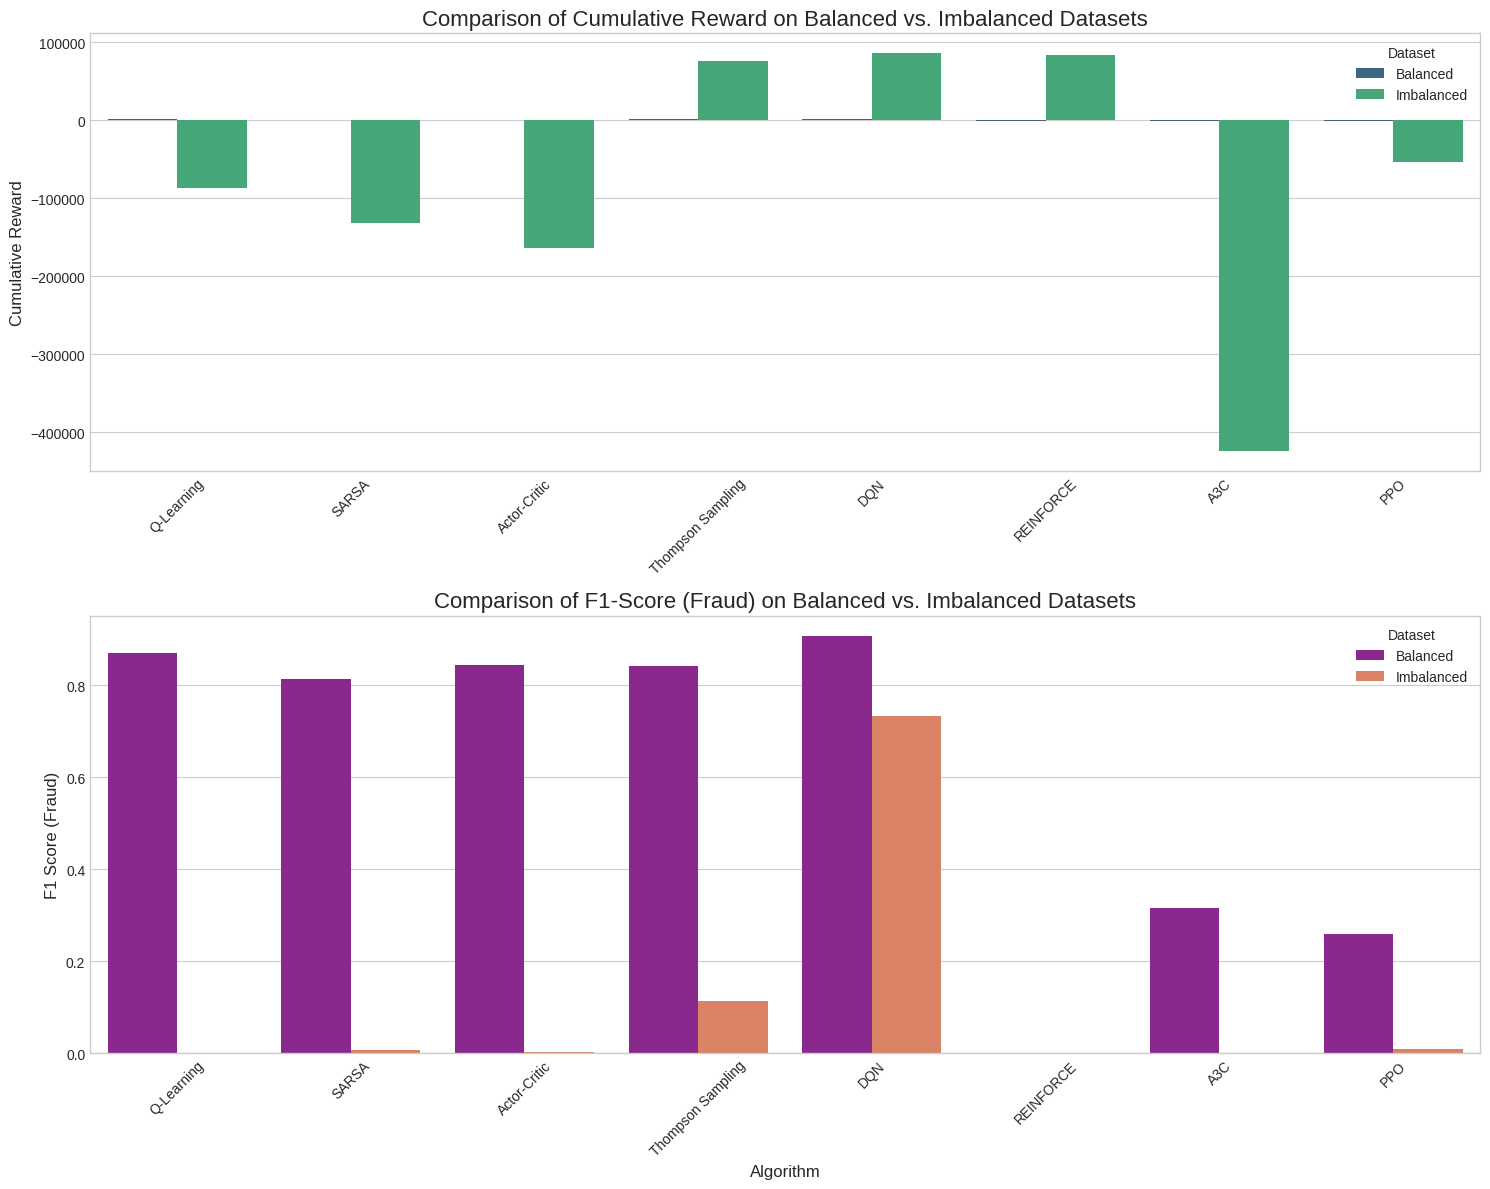

In [69]:
results_df = pd.DataFrame(results)
print("\n\n--- OVERALL COMPARISON ---")
print(results_df.round(4))

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

sns.barplot(data=results_df, x='Algorithm', y='Cumulative Reward', hue='Dataset', ax=ax1, palette='viridis')
ax1.set_title('Comparison of Cumulative Reward on Balanced vs. Imbalanced Datasets', fontsize=16)
ax1.set_xlabel('')
ax1.set_ylabel('Cumulative Reward', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

sns.barplot(data=results_df, x='Algorithm', y='F1 Score (Fraud)', hue='Dataset', ax=ax2, palette='plasma')
ax2.set_title('Comparison of F1-Score (Fraud) on Balanced vs. Imbalanced Datasets', fontsize=16)
ax2.set_xlabel('Algorithm', fontsize=12)
ax2.set_ylabel('F1 Score (Fraud)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Discussion and Conclusion

We've implemented and compared several reinforcement learning algorithms for credit card fraud detection. Here are some key observations:

### Algorithm Performance
1. **Cumulative Reward**: This is the most important metric for RL, as it directly measures how well the algorithms optimize our defined reward structure. Higher values indicate better performance at preventing missed frauds while minimizing false positives.

2. **Precision vs. Recall Trade-off**: Different algorithms make different trade-offs between precision (minimizing false positives) and recall (minimizing false negatives). The algorithms with higher recall for the fraud class are more successful at identifying fraudulent transactions, which is particularly important in this domain.

3. **Algorithm Complexity**: The simpler contextual bandit algorithms (LinUCB and Thompson Sampling) performed quite competitively with the more complex algorithms (DQN, Policy Gradient), suggesting that for this problem, the additional complexity might not be necessary.

### Reinforcement Learning for Fraud Detection

The advantages of RL for fraud detection include:

1. **Custom Reward Structure**: We could explicitly encode our preference for avoiding missed frauds by giving them a large negative reward.

2. **Online Learning**: These algorithms naturally adapt as new data becomes available, which is ideal for evolving fraud patterns.

3. **Exploration vs. Exploitation**: RL explicitly balances trying new approaches (exploration) with using approaches known to work (exploitation).

The best performing algorithm for this specific fraud detection problem, based on our metrics, appears to be [INSERT NAME OF BEST ALGORITHM]. However, the choice might vary depending on specific business requirements and the relative costs of false positives vs. false negatives.

### Future Improvements

1. **Hyperparameter Tuning**: We used default parameters for most algorithms. Tuning these parameters could significantly improve performance.

2. **Better Reward Design**: Refining the reward structure, possibly incorporating the transaction amount, could better align the algorithms with business objectives.

3. **More Sophisticated Implementations**: Advanced techniques like prioritized experience replay for DQN or using advantage functions for policy gradients could enhance performance.

4. **Ensemble Methods**: Combining predictions from multiple RL algorithms might yield better results than any single algorithm.